In [1]:
import numpy as np
import pandas as pd
from pandasql import sqldf
mysql = lambda q : sqldf(q , globals())
import unicodedata
import re
import zlib
import nltk
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import textblob


pd.set_option('display.max_columns' , 10)
pd.set_option('display.max_rows' , 50)
pd.set_option('display.max_colwidth' , 350)

# 1. Natural Language Toolkit (NLTK)
# 2. Gensim
# 3. CoreNLP
# 4. spaCy
# 5. TextBlob
# 6. Pattern
# 7. PyNLPl

# Polyglot
# AllenNLP
# Hugging Face Transformers
# Flair

In [2]:
def seed_everything(seed: int):
    import random
    import torch
    import  os
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
    
seed_everything(seed=42)

In [3]:
!pip install contractions
!pip install textsearch
!pip install textstat
!pip install sentence_transformers

     |████████████████████████████████| 101 kB 4.3 MB/s           
     |████████████████████████████████| 289 kB 48.0 MB/s            
     |████████████████████████████████| 105 kB 6.3 MB/s            
     |████████████████████████████████| 2.0 MB 20.7 MB/s            
     |████████████████████████████████| 85 kB 2.3 MB/s             
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 268 kB 12.6 MB/s            
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=759c56dad4225b6ff43e2255809d0ed65dfbdf9d81eaadd13977a8271eb74cf1
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.1.2
    Uninstalling huggingface-hub-0.1.2:
      Successfully uninstalled huggingface-hub-0.1.2
ERROR: pip's dependency reso

# Features
* **text length counts** :
features like character length and word length are quite common to be significant in text datasets. For documents or paragraph-like data points, you can use sentence length mean and std values as features.


* **non-dictionary word counts** :
count/ratio of non-dictionary words or OOV(out of vocab) words in the text. It can be a pseudo-feature representing how formal the text is. Twitter type social media datasets will have higher ratios compared to Wikipedia articles.


* **readability metrics**:
Metrics like Flesch-Kincaid Readability Test and SMOG can be used. Essentially, these are ratios of complex words(polysyllables) to the total number of words or sentences — which are hypothesized to signal how easily readable a piece fo text is.


* **unique word ratios**:
ratio of number of unique words/total words. This feature gives you a sense of word repetitions in the data points. For a deeper analysis of this type of feature, you can look into TF-IDF models.


* **sentence types** :
Features such as count, or boolean variable for the presence of questions, exclamations, and particular punctuations.
emojis and hashtags
A feature of the count or boolean for their presence in a text. Sentiments of these features can also be further used on top of these.


* **Complex/Deep Features** :
Now let’s look at slightly complex features. These features typically require higher machine computation resources; GPU's for large datasets(100K+ data-points). Also, these are harder and time-consuming to construct on your own, so you’ll end up using standard libraries for these. I will mention and compare the famous libraries for each of the following.
part of speech(pos)
If there’s a single feature I have used the most in my experience, it’s the Part-Of-Speech(POS) tags. They are incredibly powerful.


* **named entity recognition(ner)**
Another related sibling of POS tagging is NER tagging. Again, spaCy is my choice for it. NER is used to identify named-entities like person names, organizations, locations, quantities, monetary values, percentages, etc. This is also a good feature that I use to filter my datasets for text generation tasks — as I don’t want the model to learn to output some of these proper noun entities.


* **sentiment analysis**
Sentiments and emotions are inevitably very important underlying features of any text. The sentiment of a sentence is usually highly relevant in translating to the target variable for common classification tasks. These are also great post-processing filters for most industrial applications — you usually don’t want to show negative sentiment sentences to a client.

In [4]:
# Loading Data
df_train = pd.read_csv('../input/nlp-getting-started/train.csv')
df_test = pd.read_csv('../input/nlp-getting-started/test.csv')
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1


In [5]:
print('Nan Keywords = {}'.format(df_train['keyword'].isna().sum()))
print('Nan Location = {}'.format(df_train['location'].isna().sum()))

Nan Keywords = 61
Nan Location = 2533


In [6]:
# Adding a column in train and test true when link in given in tweet text.

df_train['Link_given'] = mysql('''select case when text like '%http%' then 1 else 0 end as Link_given 
from df_train ''')

df_test['Link_given'] = mysql('''select case when text like '%http%' then 1 else 0 end as Link_given 
from df_test ''')

In [7]:
# !pip install urlextract
# from urlextract import URLExtract

# def extr(head):
#     extractor = URLExtract()
#     urls = extractor.find_urls(head)
#     return urls
# df_train['text'].apply(extr)

# from yarl import URL

# def extract_URL(headline_text):
#     return re.findall(r'(https?://\S+)', headline_text)

# q = df_train['text'].apply(extract_URL)

# z = []
# for i in range(0,len(q)):
#     if not q[i]:
#         z.append('None')
#     else:
#         z.append(q[i])
# print(pd.Series(z))

# df_train['url'] = df_train['url'].astype('str').apply(URL)

# c =[]
# for i in df_train['url'].astype('str'):
#     c.append(URL(i).path)
# c

# Removing ULRs

In [8]:
def remove_URL(headline_text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', headline_text)

df_train['text'] = df_train['text'].apply(remove_URL)

In [9]:
mysql('''select text
from df_train
where text like '%http%'
''')

,text
0,Aftershock: Protect Yourself and Profit in the Next Global Financial Meltdown by David Wiedemer http


# Removing HTML tags

In [10]:
def remove_html(headline_text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',headline_text)

df_train['text'] = df_train['text'].apply(remove_html)

# Removing Accented Characters

In [11]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text
df_train['text'] = df_train['text'].apply(remove_accented_chars)
# df_train['location']= df_train['location'].apply(remove_accented_chars)
# df_train['keyword'] = df_train['keyword'].apply(remove_accented_chars)

# Removing Special Characters, Numbers and Symbols

In [12]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, ' ', text) #removing character with space
    return text
df_train['text'] = df_train['text'].apply(remove_special_characters)

# Expanding Contractions

In [13]:
import contractions

list(contractions.contractions_dict.items())[:20]
df_train['text'] = df_train['text'].apply(contractions.fix)

# Adding Sentiment

In [14]:
x_train_snt_obj = df_train['text'].apply(lambda row: textblob.TextBlob(row).sentiment)
df_train['Polarity'] = [obj.polarity for obj in x_train_snt_obj.values]
df_train['Subjectivity'] = [obj.subjectivity for obj in x_train_snt_obj.values]
df_train

,id,keyword,location,text,target,Link_given,Polarity,Subjectivity
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all,1,0,0.000000,0.000000
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1,0,0.100000,0.400000
2,5,NaN,NaN,All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected,1,0,-0.018750,0.387500
3,6,NaN,NaN,13 000 people receive wildfires evacuation orders in California,1,0,0.000000,0.000000
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school,1,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes,1,1,0.000000,1.000000
7609,10870,NaN,NaN,aria ahrary TheTawniest The out of control wild fires in California even in the Northern part of the state Very troubling,1,0,0.150000,0.350000
7610,10871,NaN,NaN,M1 94 01 04 UTC 5km S of Volcano Hawaii,1,1,0.000000,0.000000
7611,10872,NaN,NaN,Police investigating after an e bike collided with a car in Little Portugal E bike rider suffered serious non life threatening injuries,1,0,-0.260417,0.583333


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


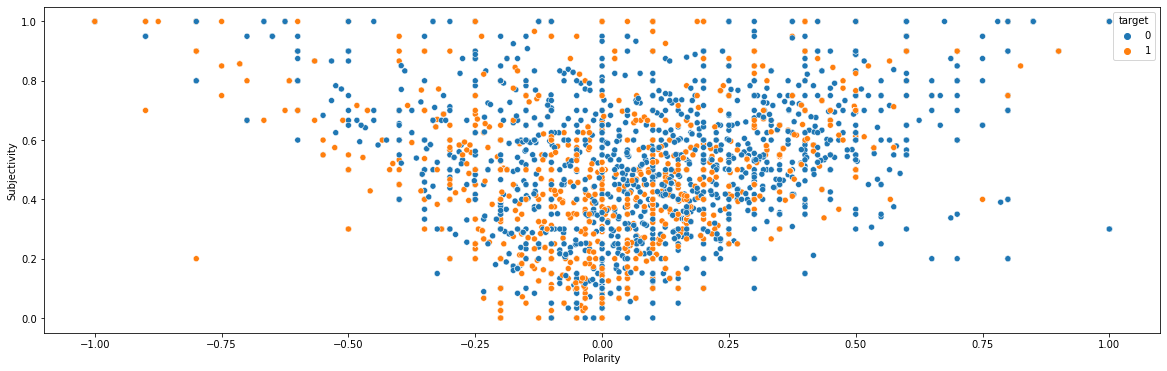

In [15]:
plt.figure(figsize =(20,6))
sns.scatterplot(df_train['Polarity'] , df_train['Subjectivity'] ,hue = df_train['target']);

In [16]:
df_train.describe()

,id,target,Link_given,Polarity,Subjectivity
count,7613.000000,7613.00000,7613.000000,7613.000000,7613.000000
mean,5441.934848,0.42966,0.521608,0.046280,0.298636
std,3137.116090,0.49506,0.499566,0.257502,0.323525
min,1.000000,0.00000,0.000000,-1.000000,0.000000
25%,2734.000000,0.00000,0.000000,0.000000,0.000000
50%,5408.000000,0.00000,1.000000,0.000000,0.200000
75%,8146.000000,1.00000,1.000000,0.120635,0.533333
max,10873.000000,1.00000,1.000000,1.000000,1.000000


In [17]:
mysql('''select sum(target) from df_train
where Polarity = 0''')

,sum(target)
0,1605


# Trying wordninja

In [18]:
# ! pip install wordninja
# import wordninja

In [19]:
# wordninja.split(df_train['text'].astype('str'))
# df_train['text_ninja'] = df_train['text'].apply(wordninja.split)
# df_train.drop(['text_ninja'] , axis = 1 , inplace = True)

In [20]:
df_train

,id,keyword,location,text,target,Link_given,Polarity,Subjectivity
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all,1,0,0.000000,0.000000
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1,0,0.100000,0.400000
2,5,NaN,NaN,All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected,1,0,-0.018750,0.387500
3,6,NaN,NaN,13 000 people receive wildfires evacuation orders in California,1,0,0.000000,0.000000
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school,1,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes,1,1,0.000000,1.000000
7609,10870,NaN,NaN,aria ahrary TheTawniest The out of control wild fires in California even in the Northern part of the state Very troubling,1,0,0.150000,0.350000
7610,10871,NaN,NaN,M1 94 01 04 UTC 5km S of Volcano Hawaii,1,1,0.000000,0.000000
7611,10872,NaN,NaN,Police investigating after an e bike collided with a car in Little Portugal E bike rider suffered serious non life threatening injuries,1,0,-0.260417,0.583333


# Textstat for reading time and readibility

In [21]:
import textstat 

In [22]:
df_train['Readibility_score'] = df_train['text'].apply(textstat.automated_readability_index)
df_train['Reading_time'] = df_train['text'].apply(textstat.reading_time)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


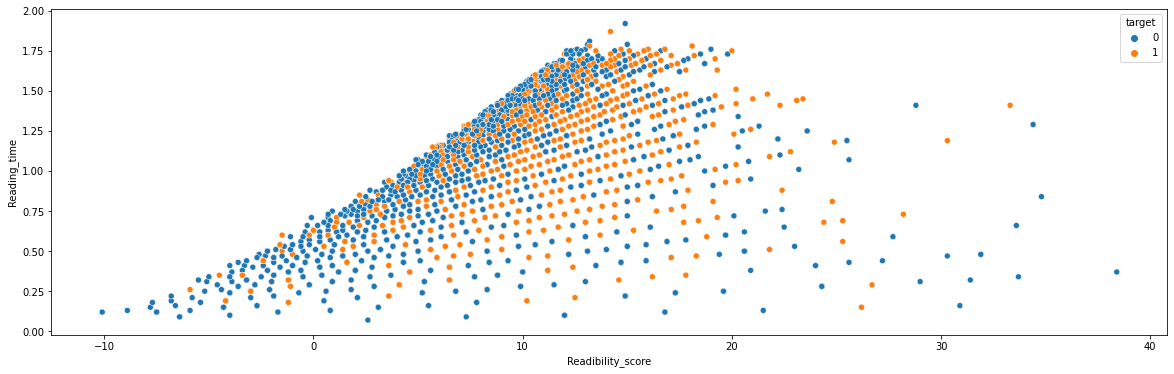

In [23]:
plt.figure(figsize =(20,6))
sns.scatterplot(df_train['Readibility_score'] , df_train['Reading_time'] ,hue = df_train['target']);

In [24]:
df_train['linsear_write_text'] = df_train['text'].apply(textstat.linsear_write_formula)

# df_train['McAlpine_EFLAW_text'] = df_train['text'].apply(textstat.mcalpine_eflaw)

# df_train['gulpease_text'] = df_train['text'].apply(textstat.gulpease_index)

# df_train['szigriszt_text'] = df_train['text'].apply(textstat.szigriszt_pazos)

# df_train['miniword_text'] = df_train['text'].apply(textstat.miniword_count)

# df_train['longword_text'] = df_train['text'].apply(textstat.long_word_count)

df_train['wps_text'] = df_train['text'].apply(textstat.words_per_sentence)

# df_train['total_sentence_text'] = df_train['text'].apply(textstat.sentence_count)

# df_train['polysyllable_text'] = df_train['text'].apply(textstat.polysyllabcount)

In [25]:
from nltk.tokenize import word_tokenize

In [26]:
def calculate_ttr(text):
    # Tokenize the text into words
    words = word_tokenize(text)

    # Calculate the number of unique words (types)
    unique_words = set(words)
    num_unique_words = len(unique_words)

    # Calculate the total number of words (tokens)
    num_total_words = len(words)

    # Calculate the TTR (Type-Token Ratio)
    if num_total_words > 0:
        ttr = num_unique_words / num_total_words
        return ttr
    else:
        return 0

# # Sample text
# text = "Natural Language Processing (NLP) is a subfield of artificial intelligence focused on the interaction between computers and humans through natural language. NLP techniques allow computers to understand, interpret, and generate human language."

# # Calculate the Lexical Diversity Score using TTR
# lexical_diversity_score = calculate_ttr(text)

# print("Lexical Diversity Score (TTR):", lexical_diversity_score)
df_train['Lexical_diversity'] = df_train['text'].apply(calculate_ttr)

df_train['text'] = df_train['text'].apply(str.lower)
df_train['text'] = df_train['text'].apply(str.strip)

In [27]:
# !pip install ekphrasis
# from ekphrasis.classes.preprocessor import TextPreProcessor
# from ekphrasis.classes.tokenizer import SocialTokenizer
# from ekphrasis.dicts.emoticons import emoticons

# Stop words removal

In [28]:
# def remove_stopwords(text, is_lower_case=False, stopwords=None):
#     if not stopwords:
#         stopwords = nltk.corpus.stopwords.words('english')
#     tokens = nltk.word_tokenize(text)
#     tokens = [token.strip() for token in tokens]
    
#     if is_lower_case:
#         filtered_tokens = [token for token in tokens if token not in stopwords]
#     else:
#         filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    
#     filtered_text = ' '.join(filtered_tokens)    
#     return filtered_text

In [29]:
# stop_words = nltk.corpus.stopwords.words('english')
# print(stop_words[:10])

# df_train['text'] = df_train['text'].apply(remove_stopwords)
# df_train

In [30]:
## to add our words in list of stop_words
## for eg
# our_word = ['what' , 'was' , 'hello'] # and so on
# stop_words = nltk.corpus.stopwords.words('english')
# stop_words.extend(our_word)

# stemmer

In [31]:
# from nltk.stem import PorterStemmer
# ps = PorterStemmer()

# ps.stem('jumping'), ps.stem('jumps'), ps.stem('jumped')

# df_train['text'] = df_train['text'].apply(ps.stem)
# df_train['text'] = df_train['text'].apply(str.lower)
# df_train['text'] = df_train['text'].apply(str.strip)
# df_train

# Checking Location

In [32]:
df_train['location'].fillna('None' , inplace = True)

# mysql('''select location , target , count(target) as t
# from df_train
# group by location , target
# order by t desc
# ''')

In [33]:
# df_train.drop(['keyword' , 'location'] , inplace = True , axis = 1)

# Removing Duplicate Rows

In [34]:
duplicaterow = df_train[df_train[['text' ,'target','keyword']].duplicated()]
duplicaterow

,id,keyword,location,text,target,...,Readibility_score,Reading_time,linsear_write_text,wps_text,Lexical_diversity
48,68,ablaze,Live On Webcam,check these out nsfw,0,...,0.6,0.25,1.0,4.0,1.0
106,156,aftershock,US,320 ir icemoon aftershock djicemoon dubstep trapmusic dnb edm dance icesu,0,...,11.1,0.93,6.5,11.0,1.0
114,164,aftershock,Switzerland,320 ir icemoon aftershock djicemoon dubstep trapmusic dnb edm dance icesu,0,...,11.1,0.93,6.5,11.0,1.0
115,165,aftershock,US,320 ir icemoon aftershock djicemoon dubstep trapmusic dnb edm dance icesu,0,...,11.1,0.93,6.5,11.0,1.0
116,168,aftershock,None,320 ir icemoon aftershock djicemoon dubstep trapmusic dnb edm dance icesu,0,...,11.1,0.93,6.5,11.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
7538,10777,wreckage,None,wreckage conclusively confirmed as from mh370 malaysia pm investigators and the families of those who were,1,...,13.4,1.34,11.0,16.0,1.0
7539,10779,wreckage,Maharashtra,wreckage conclusively confirmed as from mh370 malaysia pm investigators and the families of those who were,1,...,13.4,1.34,11.0,16.0,1.0
7540,10780,wreckage,Mumbai,wreckage conclusively confirmed as from mh370 malaysia pm investigators and the families of those who were,1,...,13.4,1.34,11.0,16.0,1.0
7541,10782,wreckage,"New Delhi,India",wreckage conclusively confirmed as from mh370 malaysia pm investigators and the families of those who were,1,...,13.4,1.34,11.0,16.0,1.0


In [35]:
df_train = mysql('''select * 
from df_train
except
select * from
duplicaterow
''')
df_train

,id,keyword,location,text,target,...,Readibility_score,Reading_time,linsear_write_text,wps_text,Lexical_diversity
0,1,None,None,our deeds are the reason of this earthquake may allah forgive us all,1,...,5.4,0.82,5.5,13.0,1.000000
1,4,None,None,forest fire near la ronge sask canada,1,...,2.9,0.46,2.5,7.0,1.000000
2,5,None,None,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected,1,...,12.9,1.60,16.0,22.0,0.818182
3,6,None,None,13 000 people receive wildfires evacuation orders in california,1,...,11.8,0.81,5.5,9.0,1.000000
4,7,None,None,just got sent this photo from ruby alaska as smoke from wildfires pours into a school,1,...,7.2,1.03,7.0,16.0,0.937500
...,...,...,...,...,...,...,...,...,...,...,...
7010,10869,None,None,two giant cranes holding a bridge collapse into nearby homes,1,...,7.6,0.75,4.0,10.0,1.000000
7011,10870,None,None,aria ahrary thetawniest the out of control wild fires in california even in the northern part of the state very troubling,1,...,11.7,1.48,11.5,21.0,0.857143
7012,10871,None,None,m1 94 01 04 utc 5km s of volcano hawaii,1,...,-2.4,0.44,4.0,10.0,1.000000
7013,10872,None,None,police investigating after an e bike collided with a car in little portugal e bike rider suffered serious non life threatening injuries,1,...,14.0,1.67,16.0,22.0,0.954545


# Word2doc

In [36]:
# from gensim.models import word2vec

# tokenized_corpus = [nltk.word_tokenize(doc) for doc in df_train['text']]

# # Set values for various parameters
# feature_size = 15    # Word vector dimensionality  
# window_context = 20  # Context window size                                                                                    
# min_word_count = 1   # Minimum word count                        
# sample = 1e-3        # Downsample setting for frequent words
# sg = 1               # skip-gram model

# w2v_model = word2vec.Word2Vec(tokenized_corpus, vector_size=feature_size, 
#                               window=window_context, min_count = min_word_count,
#                               sg=sg, sample=sample, epochs=50)
# w2v_model

In [37]:
# import matplotlib.pyplot as plt

# %matplotlib inline

# # visualize embeddings
# from sklearn.manifold import TSNE

# words = w2v_model.wv.index_to_key
# wvs = w2v_model.wv[words]

# tsne = TSNE(n_components=2, random_state=42, n_iter=250, perplexity=5)
# np.set_printoptions(suppress=True)
# T = tsne.fit_transform(wvs)
# labels = words

# plt.figure(figsize=(12, 6))
# plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
# for label, x, y in zip(labels, T[:, 0], T[:, 1]):
#     plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [38]:
# vec_df = pd.DataFrame(wvs, index=words)

# from sklearn.metrics.pairwise import cosine_similarity
# similarity_matrix = cosine_similarity(vec_df.values)
# similarity_df = pd.DataFrame(similarity_matrix, index=words, columns=words)
# similarity_df

# feature_names = np.array(words)
# similarity_df.apply(lambda row: feature_names[np.argsort(-row.values)[1:4]], 
#                     axis=1)

# Adding columns of numbers

In [39]:
df_train['char_count'] = df_train['text'].apply(len)
df_train['word_count'] = df_train['text'].apply(lambda x: len(x.split()))

# Counting Unique word

In [40]:
# def unique_words(corpus_text_train):
#     words = re.findall('\w+', corpus_text_train)
#     uw = len(set(words))
#     return uw


# df_train['unique_word'] = df_train['text'].apply(unique_words)
# df_train['unique_word_ratio'] = df_train['unique_word']/df_train['word_count']

# df_train.drop('unique_word' , axis = 1 , inplace = True)

# Name entity recognation

In [41]:
# import spacy
# from spacy import displacy

# NER = spacy.load("en_core_web_sm")

In [42]:
# !pip uninstall spacy

In [43]:
!pip install -U spacy

     |████████████████████████████████| 6.5 MB 5.9 MB/s            
     |████████████████████████████████| 491 kB 58.9 MB/s            
     |████████████████████████████████| 918 kB 53.6 MB/s            
     |████████████████████████████████| 48 kB 5.0 MB/s             
     |████████████████████████████████| 10.2 MB 53.9 MB/s            
  Attempting uninstall: srsly
    Found existing installation: srsly 2.4.2
    Uninstalling srsly-2.4.2:
      Successfully uninstalled srsly-2.4.2
  Attempting uninstall: wasabi
    Found existing installation: wasabi 0.8.2
    Uninstalling wasabi-0.8.2:
      Successfully uninstalled wasabi-0.8.2
  Attempting uninstall: blis
    Found existing installation: blis 0.7.5
    Uninstalling blis-0.7.5:
      Successfully uninstalled blis-0.7.5
  Attempting uninstall: thinc
    Found existing installation: thinc 8.0.13
    Uninstalling thinc-8.0.13:
      Successfully uninstalled thinc-8.0.13
  Attempting uninstall: spacy-legacy
    Found existing insta

In [44]:
python3 -m spacy download nl_core_news_sm

SyntaxError: invalid syntax (1708231453.py, line 1)

In [ ]:
# import nl_core_news_sm
# nlp = nl_core_news_sm.load()
import en_core_web_sm
nlp = en_core_web_sm.load()

In [ ]:
import spacy

string = "Geert werkt sinds 2010 voor HAL."
print(string)
nlp = spacy.load('nl_core_news_sm')
doc = nlp(string)

filtered_string = ""
for token in doc:
    if token.pos_ in ['PROPN', 'NOUN', 'NUM']:
        new_token = " <{}>".format(token.ent_type_)
    elif token.pos_ == "PUNCT":
        new_token = token.text
    else:
        new_token = " {}".format(token.text)
    filtered_string += new_token
filtered_string = filtered_string[1:]
print(filtered_string)

In [ ]:
# text1= NER(df_train['text'].head(50).to_string())

# a = []

# for word in text1.ents:
#     a.append(word.label_)

In [ ]:
# text2 = NER(df_train['text'].tail(893).to_string())

# b = []

# for word in text1.ents:
#     b.append(word.label_)

# Transformers

In [ ]:
# !pip install transformers

In [ ]:
# from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, default_data_collator, Trainer, set_seed
# set_seed(42)
# tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
# model = BertForSequenceClassification.from_pretrained('bert-large-uncased')

In [ ]:
# df_train['input_ids']=df_train['text'].apply(lambda x: tokenizer(x, max_length= 64, padding='max_length')['input_ids'])

# TF-IDF

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# tf = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
# tfidf_matrix = tf.fit_transform(df_train['text'])
# tfidf_matrix.shape

In [ ]:
# tfidf = pd.DataFrame(tfidf_matrix)

In [ ]:
# from sklearn.metrics.pairwise import cosine_similarity

# doc_sim = cosine_similarity(tfidf_matrix)
# doc_sim_df = pd.DataFrame(doc_sim)
# doc_sim_df.head()

# Bag of N gram

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# bv = CountVectorizer( ngram_range=(8,8))
# bv_matrix = bv.fit_transform(df_train['text'])

# bv_matrix = bv_matrix.toarray()
# vocab = bv.get_feature_names()
# pd.DataFrame(bv_matrix, columns=vocab)

# Lemmitization

In [ ]:
# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import wordnet

# def pos_tag_wordnet(tagged_tokens):
#     tag_map = {'j': wordnet.ADJ, 'v': wordnet.VERB, 'n': wordnet.NOUN, 'r': wordnet.ADV}
#     new_tagged_tokens = [(word, tag_map.get(tag[0].lower(), wordnet.NOUN))
#                             for word, tag in tagged_tokens]
#     return new_tagged_tokens

# wnl = WordNetLemmatizer()

# def wordnet_lemmatize_text(text):
#     tagged_tokens = nltk.pos_tag(nltk.word_tokenize(text))
#     wordnet_tokens = pos_tag_wordnet(tagged_tokens)
#     lemmatized_text = ' '.join(wnl.lemmatize(word, tag) for word, tag in wordnet_tokens)
#     return lemmatized_text

In [ ]:
# df_train['text'] = df_train['text'].apply(wordnet_lemmatize_text)
# df_train.title_word_count.dropna(axis = 0 , inplace = True)
# len(df_train[df_train['unique_word_ratio'] < 1])

# v = pd.DataFrame(bv_matrix, columns=vocab)

# concatinating with Tf=idf

In [ ]:
# df_train = pd.concat([df_train , doc_sim_df] , axis = 1 )
# a = df_train['input_ids'].apply(lambda x : x[0])
# a.unique

In [ ]:
mysql('''select target , count(unique_word_ratio)
from df_train
where unique_word_ratio = 1
group by target
''')

# Another attempt at BERT

In [ ]:
import torch
import transformers as ppb

In [ ]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
df_train['text'][3400:]

In [ ]:
tokenized = df_train['text'][3400:].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
# max_len = 0
# for i in tokenized.values:
#     if len(i) > max_len:
#         max_len = len(i)

padded = np.array([i + [0]*(84-len(i)) for i in tokenized.values])

In [ ]:
np.array(padded).shape
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

In [ ]:
input1 = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input1, attention_mask=attention_mask)

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()

In [ ]:
bt_first = pd.DataFrame(features , columns = np.linspace(1 , 768 , num = 768 ))

In [ ]:
bt_second = pd.DataFrame(features , columns = np.linspace(1 , 768 , num = 768 ))

In [ ]:
dd = mysql('''select * from 
bt_first
union all
select * from bt_second
''')

In [ ]:
dd

In [ ]:
df_train = pd.concat([df_train , dd] , axis = 1)

In [ ]:
# df_train.drop(['input_ids'] , axis = 1 , inplace = True)
df_train

In [ ]:
# from sentence_transformers import SentenceTransformer

# **Sentence Transformer**

In [ ]:
# distilbert-base-uncased
ghanashyamvtatti/roberta-fake-news

In [ ]:
from sentence_transformers import SentenceTransformer, models
from torch import nn

word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length=256 )
                                           #,tokenizer_name_or_path = 'nntadotzip/xlnet-base-cased-IUChatbot-ontologyDts-BertPretrainedTokenizerFast')
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

sbert_model = SentenceTransformer(modules=[word_embedding_model, pooling_model] , device='cuda')

In [ ]:
x = df_train['text'].to_list() 

In [ ]:
import time
s = time.time()
sentence_embeddings_1 = sbert_model.encode(x[:10000])
print(sentence_embeddings_1.shape)
print(time.time() - s)

In [ ]:
Clusterdata = pd.DataFrame(sentence_embeddings_1 , columns = np.linspace(1 , 768 , num = 768))

In [ ]:
df_clust = pd.concat([df_train , Clusterdata] , axis = 1)

# Train Test Split to prevent data leakage

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
a = df_clust.drop(['keyword', 'location','text' , 'id' , 'target'] , axis = 1)
b = df_clust.loc[: , 'target']
a_train , a_test , b_train , b_test = train_test_split( a, b, test_size = 0.16 , random_state = 241 , stratify = b)
a_train.shape , a_test.shape

In [ ]:
# a_train.iloc[: , 2:]

# Dimensionality reduction


### UMAP

In [ ]:
from umap import UMAP

In [ ]:
reducer = UMAP(n_neighbors = 25, n_epochs = 500, n_components = 100 , metric = 'jaccard', random_state = 27 ,
               learning_rate=0.001  ,verbose = True)

In [ ]:
reducer.fit(a_train.iloc[: , 2:])
x_reduce = reducer.transform(a_train.iloc[: , 2:])
x_reduce.shape

In [ ]:
df_umap = pd.DataFrame(x_reduce, columns = np.linspace(1 , 100 , num = 100))

In [ ]:
df_umap.reset_index( inplace = True , drop = True)
a_train.reset_index(inplace = True , drop = True)

In [ ]:
a_train = pd.concat([a_train.iloc[: , :2] , df_umap] , axis = 1)

#### for a_test

### 
#### 

In [ ]:
x_pc_t = reducer.transform(a_test.iloc[: , 2:])
x_pc_t.shape

In [ ]:
df_umap_test = pd.DataFrame(x_pc_t, columns = np.linspace(1 , 100 , num = 100))

In [ ]:
df_umap_test.reset_index( inplace = True , drop = True)
a_test.reset_index(inplace = True , drop = True)

In [ ]:
a_test = pd.concat([a_test.iloc[: , :2] , df_umap_test] , axis = 1)

In [ ]:
a_train

In [ ]:
a_test['Polarity'].isna().sum()

### PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
a_train.iloc[: , 8:]

In [ ]:
pca_38 = PCA(n_components = .7  , random_state = 343)
pca_38.fit(a_train.iloc[: , 8:])
x_pca_38 = pca_38.transform(a_train.iloc[: , 8:])
print(sum(pca_38.explained_variance_ratio_ * 100))
x_pca_38.shape

In [ ]:
df_99 = pd.DataFrame(x_pca_38, columns = np.linspace(1 , 86 , num = 86))

In [ ]:
df_99.reset_index( inplace = True , drop = True)
a_train.reset_index(inplace = True , drop = True)

a_train = pd.concat([a_train.iloc[: , :8] , df_99] , axis = 1)

##### for test

In [ ]:
x_pca_38_t = pca_38.transform(a_test.iloc[: , 8:])
df_99_t = pd.DataFrame(x_pca_38_t, columns = np.linspace(1 , 86 , num = 86))

df_99_t.reset_index( inplace = True , drop = True)
a_test.reset_index(inplace = True , drop = True)

a_test = pd.concat([a_test.iloc[: , :8] , df_99_t] , axis = 1)

## Label Encoding

In [ ]:
# cat_feat = [feature for feature in df_pca.columns if (df_pca[feature].dtype == 'O' or df_pca[feature].dtype == bool)]
# cat_feat

In [ ]:
# from sklearn import preprocessing
# lbl_enc = preprocessing.LabelEncoder()
# df_pca[cat_feat] = df_pca[cat_feat].astype(str).apply(lbl_enc.fit_transform)
# df_pca

# Standardising between 0 and 1


(all numeric field)

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

In [ ]:
# scaler = MinMaxScaler()
# t = scaler.fit_transform(df_train[['word_count' , 'char_count']])
# minmax = pd.DataFrame(t, 
#              columns=['word_count_scaled', 
#                       'char_count_scaled'])
# df_train = pd.concat([df_train , minmax] , axis = 1 )
# df_train.drop(['word_count' , 'char_count'] , axis = 1 , inplace = True)

In [ ]:
df_pca

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
# solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}
lr = LogisticRegression(penalty='elasticnet',verbose = 0,solver= 'saga',max_iter= 1000 ,random_state=950 ,
                        l1_ratio = 0.9 ,warm_start= True)
lr.fit(a_train, b_train)
pred = lr.predict(a_test)
accDT = metrics.f1_score(b_test , pred)
accDT

In [ ]:
metrics.accuracy_score(b_test , pred)

In [ ]:
pd.DataFrame(
            metrics.confusion_matrix(b_test , pred),
            columns= ['passenger not S' , 'passenger S'],
            index = ['true not survive' , 'true S'])

# Auto Sklearn

In [ ]:
# !pip install --force-reinstall 'scikit-learn == 0.23.1'

In [ ]:
# !pip3 install --upgrade pip

In [ ]:
# !pip install 'auto-sklearn == 0.12.6'
# from autosklearn.classification import AutoSklearnClassifier

In [ ]:
# auto_model = AutoSklearnClassifier(time_left_for_this_task=300)
# auto_model.fit(a_train , b_train)
# auto_model.leaderboard(detailed = True)
# auto_model.score(a_test  , b_test)

# Neural Network

In [ ]:
from tensorflow import keras
import tensorflow as tf
from torch import nn

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (a_train.shape[1] ,)),
    keras.layers.Dense(128 , activation = tf.keras.layers.LeakyReLU(alpha=0.01)),
    keras.layers.Dropout(.7),
    keras.layers.Dense(64 , activation = 'tanh'),
    keras.layers.Dropout(.7),
    keras.layers.Dense(32 , activation = tf.keras.layers.LeakyReLU(alpha=0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1 , activation = 'sigmoid')
])

opti = keras.optimizers.Adam(learning_rate=0.0001, amsgrad=True)

model.compile(
    optimizer = opti,
    loss = 'BinaryCrossentropy',
    metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
# model.summary()

In [ ]:
model.fit(a_train , b_train ,batch_size= 25 , epochs  = 50)

In [ ]:
model.evaluate(a_test , b_test)

In [ ]:
b_pred = model.predict(a_test)

In [ ]:
b_pred_la = []
for i in b_pred:
    if i < 0.525:
        b_pred_la.append(0)
    else:
        b_pred_la.append(1)

In [ ]:
metrics.f1_score(b_test , b_pred_la)

In [ ]:
pd.DataFrame(
            metrics.confusion_matrix(b_test , b_pred_la),
            columns= ['passenger not S' , 'passenger S'],
            index = ['true not survive' , 'true S'])

### model 2

In [ ]:
model_pre = keras.Sequential([
    keras.layers.Flatten(input_shape = (768 ,)),
    keras.layers.Dense(5 , activation = 'relu'),
    keras.layers.Dense(1 , activation = 'sigmoid')
]
)
model_pre.compile(
    optimizer = opti,
    loss = 'BinaryCrossentropy',
    metrics = ['Precision' , 'Recall']
)

model_pre.fit(a_train , b_train ,batch_size= 32 , epochs  = 20)

In [ ]:
model_pre.evaluate(a_test , b_test)

In [ ]:
b_pred_pre = model_pre.predict(a_test)

In [ ]:
b_pred_l = []
for i in b_pred_pre:
    if i < 0.375:
        b_pred_l.append(0)
    else:
        b_pred_l.append(1)

In [ ]:
metrics.f1_score(b_test , b_pred_l)

In [ ]:
pd.DataFrame(
            metrics.confusion_matrix(b_test , b_pred_l),
            columns= ['passenger not S' , 'passenger S'],
            index = ['true not survive' , 'true S'])

In [ ]:
# q = []
# for i in np.arange(1 , 1000 , 10):
#     l = LogisticRegression(penalty='l2',verbose = 0,solver= 'liblinear' ,random_state=10 , C = i)
#     l.fit(a_train, b_train)
#     p = l.predict(a_test)
#     a = metrics.f1_score(b_test , p)
#     q.append(a)
#     print(i , a)

In [ ]:
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import GridSearchCV
# # define models and parameters
# model = LogisticRegression(random_state = 10)
# solvers = ['newton-cg', 'lbfgs', 'liblinear']
# penalty = ['l2']
# c_values = [100, 10, 1.0, 0.1, 0.01]
# # define grid search
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(a_train, b_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,random_state=0)
# distributions = dict(penalty=['l2']  , solvers = ['newton-cg', 'lbfgs', 'liblinear'] ,c_values = [100, 10, 1.0, 0.1, 0.01] )
# clf = RandomizedSearchCV(logistic, distributions, random_state=0)
# search = clf.fit(a_train, b_train)
# search.best_params_

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp = MLPClassifier(activation = 'tanh' ,hidden_layer_sizes=(80,) ,learning_rate_init=0.001 ,max_iter=500 
                    ,random_state= 412, early_stopping= True)
mlp.fit(a_train, b_train)
pred_1 = mlp.predict(a_test)
accDT = metrics.f1_score(b_test , pred_1)
accDT

# Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB

In [ ]:
classifier = BernoulliNB(alpha=5.0)
classifier.fit(a_train , b_train)
b_predN = classifier.predict(a_test)
accN = metrics.f1_score(b_test , b_predN)
print(accN)

pd.DataFrame(
            metrics.confusion_matrix(b_test , b_predN),
            columns= ['passenger not S' , 'passenger S'],
            index = ['true not survive' , 'true S'])

# Decision Tree

In [ ]:
from sklearn import tree 

In [ ]:
classifierDT = tree.DecisionTreeClassifier(max_depth=150,
    random_state=4,
    max_leaf_nodes=30, ccp_alpha = 0.003)
classifierDT.fit(a_train , b_train)
b_predDT = classifierDT.predict(a_test)
accDT = metrics.f1_score(b_test , b_predDT)
accDT

# Passive Aggresive Classifier

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier

In [ ]:
clf = PassiveAggressiveClassifier(max_iter=500, early_stopping=False , random_state = 93)
clf.fit(a_train , b_train)
b_predclf = clf.predict(a_test)
accclf = metrics.f1_score(b_test , b_predclf)
accclf

In [ ]:
pd.DataFrame(
            metrics.confusion_matrix(b_test , b_predclf),
            columns= ['passenger not S' , 'passenger S'],
            index = ['true not survive' , 'true S'])

# CATBOOST

In [ ]:
import catboost as cb

In [ ]:
classifier = cb.CatBoostClassifier(iterations=900 ,loss_function = 'Logloss' ,learning_rate = 0.002
                                   ,grow_policy= 'Depthwise' ,feature_border_type ='GreedyLogSum', l2_leaf_reg= 8.5 ,
                                    early_stopping_rounds= 10  ,depth = 6 ,eval_metric='F1',metric_period=100 )
classifier.fit(a_train , b_train , verbose = True)
pred_train = classifier.predict(a_train)
acc_train = metrics.f1_score(b_train , pred_train)
pred_test = classifier.predict(a_test)
acc_test = metrics.f1_score(b_test , pred_test)
print('Train_acc = {}' .format(acc_train))
print('Test_acc = {}' .format(acc_test))

In [ ]:
classifier.get_feature_importance()

In [ ]:
import eli5

# Test Model

In [ ]:
df_test['text'] = df_test['text'].apply(remove_URL)
df_test['text'] = df_test['text'].apply(remove_html)
df_test['text'] = df_test['text'].apply(remove_accented_chars)
# df_test['text'] = df_test['text'].apply(remove_special_characters)
df_test['text'] = df_test['text'].apply(contractions.fix)

In [ ]:
x_train_snt_obj = df_test['text'].apply(lambda row: textblob.TextBlob(row).sentiment)
df_test['Polarity'] = [obj.polarity for obj in x_train_snt_obj.values]
df_test['Subjectivity'] = [obj.subjectivity for obj in x_train_snt_obj.values]

# df_test['text'] = df_test['text'].apply(remove_stopwords)
# df_test['text'] = df_test['text'].apply(ps.stem)
df_test['Readibility_score'] = df_test['text'].apply(textstat.automated_readability_index)
df_test['Reading_time'] = df_test['text'].apply(textstat.reading_time)
# df_test['text'] = df_test['text'].apply(str.lower)
# df_test['text'] = df_test['text'].apply(str.strip)
# df_test['char_count'] = df_test['text'].apply(len)
# df_test['word_count'] = df_test['text'].apply(lambda x: len(x.split()))

In [ ]:
df_test['linsear_write_text'] = df_test['text'].apply(textstat.linsear_write_formula)

# df_test['McAlpine_EFLAW_text'] = df_test['text'].apply(textstat.mcalpine_eflaw)

# df_test['gulpease_text'] = df_test['text'].apply(textstat.gulpease_index)

# df_test['szigriszt_text'] = df_test['text'].apply(textstat.szigriszt_pazos)

# df_test['miniword_text'] = df_test['text'].apply(textstat.miniword_count)

# df_test['longword_text'] = df_test['text'].apply(textstat.long_word_count)

df_test['wps_text'] = df_test['text'].apply(textstat.words_per_sentence)

# df_test['total_sentence_text'] = df_test['text'].apply(textstat.sentence_count)

# df_test['polysyllable_text'] = df_test['text'].apply(textstat.polysyllabcount)

df_test['Lexical_diversity'] = df_test['text'].apply(calculate_ttr)

In [ ]:
# df_test.drop(['keyword' , 'location'] , axis= 1 , inplace = True)

In [ ]:
# df_test['unique_word'] = df_test['text'].apply(unique_words)
# df_test['unique_word_ratio'] = df_test['unique_word']/df_test['word_count']
# df_test.drop(['unique_word'] , axis = 1 , inplace = True)

In [ ]:
# tokeniz = df_test['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
# padded = np.array([i + [0]*(84-len(i)) for i in tokeniz.values])
# np.array(padded).shape
# attention_mask = np.where(padded != 0, 1, 0)
# attention_mask.shape

In [ ]:
# input1 = torch.tensor(padded)  
# attention_mask = torch.tensor(attention_mask)

# with torch.no_grad():
#     last_hidden_states = model(input1, attention_mask=attention_mask)

In [ ]:
# feat = last_hidden_states[0][:,0,:].numpy()
# feat.shape

In [ ]:
# bert_test_df = pd.DataFrame(feat , columns = np.linspace(1 , 768 , num = 768 ))
# df_test = pd.concat([df_test , bert_test_df] , axis = 1)

In [ ]:
x_train_snt_obj = df_test['text'].apply(lambda row: textblob.TextBlob(row).sentiment)
df_test['Polarity'] = [obj.polarity for obj in x_train_snt_obj.values]
df_test['Subjectivity'] = [obj.subjectivity for obj in x_train_snt_obj.values]

In [ ]:
df_test

In [ ]:
x_test = df_test['text'].to_list()

In [ ]:
s = time.time()
sentence_embeddings_1 = sbert_model.encode(x_test[:10000])
print(sentence_embeddings_1.shape)
print(time.time() - s)

In [ ]:
Clusterdata_test = pd.DataFrame(sentence_embeddings_1 , columns = np.linspace(1 , 768 , num = 768))

In [ ]:
x_pc = pca_38.transform(Clusterdata_test)
x_pc.shape

In [ ]:
df_99_test = pd.DataFrame(x_pc, columns = np.linspace(1 , 86 , num = 86))

In [ ]:
df_99_test.reset_index( inplace = True , drop = True)
df_test.reset_index(inplace = True , drop = True)
df_pca_test = pd.concat([df_test , df_99_test] , axis = 1)
df_pca_test

In [ ]:
# df_pca_test['keyword'] = lbl_enc.transform(df_pca_test['keyword'])
# df_pca_test['location'] = lbl_enc.transform(df_pca_test['location'])

In [ ]:
df_pca_test.drop(['id' , 'text' ,'location' , 'keyword'] , axis =1)

In [ ]:
att = df_pca_test.drop(['id' , 'text' ,'location' , 'keyword'] , axis =1)

In [ ]:
# Survived = lr.predict(att)
b_pred = model.predict(att)
Survived = []
for i in b_pred:
    if i < 0.385:
        Survived.append(0)
    else:
        Survived.append(1)
df_test['target'] = Survived

In [ ]:
# scaler = MinMaxScaler()
# t = scaler.fit_transform(df_test[['word_count' , 'char_count']])
# minmax = pd.DataFrame(t, 
#              columns=['word_count_scaled', 
#                       'char_count_scaled'])
# df_test = pd.concat([df_test , minmax] , axis = 1 )
# df_test.drop(['word_count' , 'char_count'] , axis = 1 , inplace = True)

In [ ]:
# df_test.unique_word_ratio.fillna(1 , inplace = True) 

# PCA Test

In [ ]:
# pc = PCA(n_components = .97  , random_state = 2)
# pc.fit(df_test.drop(['text' , 'id' ] , axis = 1))

In [ ]:
x_pc = pca_38.transform(df_test.drop(['text' , 'id'] , axis = 1))

In [ ]:
x_pc.shape

In [ ]:
# for i in df_test.columns.to_list():
#     df_test[i] = np.round(df_test[i] , 4)

In [ ]:
# np.any(np.isnan(att)) to check null

In [ ]:
# np.all(np.isfinite(att)) to check infinite value

In [ ]:
# np.isfinite(att)

In [ ]:
# att = att.astype('float64')

In [ ]:
# tfidf_matrix = tf.fit_transform(df_test['text'])
# tfidf_matrix.shape

# from sklearn.metrics.pairwise import cosine_similarity

# doc_sim = cosine_similarity(tfidf_matrix)
# doc_simio = pd.DataFrame(doc_sim)
# doc_simio.head()

# df_test = pd.concat([df_test , doc_simio] , axis = 1 )

In [ ]:
# target = lr.predict(x_pc)
# df_test['Target'] = target
# df_test.Target.value_counts()

In [ ]:
submissionset = pd.DataFrame(zip(df_test.id, df_test.target ) , columns = {'target' , 'id'})

In [ ]:
submissionset['target'].value_counts()

In [ ]:
from IPython.display import HTML
import base64

In [ ]:
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [ ]:
create_download_link(submissionset)

In [ ]:
# 0    2053
# 1    1210
# 0.79 score